# Frequency

Get frequency statistics for letters, digraphs, and trigraphs to start deciphering.

In [1]:
from collections import Counter

import matplotlib.pyplot as plt

from main import rotate

In [2]:
with open("ciphertext.txt") as f:
    text = f.read()

Let's see if this is a rotation cipher (Caesar). If it is, the most common letters will have TEA and O. Any rotation that has those as the most common letters is a candidate.

In [3]:
for rot in range(26):
    # print(rotate(text[:90],rot))
    rotated = rotate(text, rot)
    most_common = [c[0] for c in Counter(rotated).most_common(12)][2:]
    if set(most_common) >= set("TEAO"):
        print(rot, most_common)

8 ['T', 'I', 'A', 'E', 'O', 'U', 'P', 'N', 'H', 'F']


In [5]:
print(rotate(text, 8)[:100])

AYSDG44
NEYOMEDZKQHQAUQMFUWQ AHORUOZDPHQRLDRZDD PZDYRTEZAONIEMELU WPHGMXPATMKUJIPBUGOD GAZNIDPVEIZTS


Okay, it probably isn't a Caesar cipher. Let's do a classical frequency analysis and see if it is a different sort of alphabetic substitution cipher

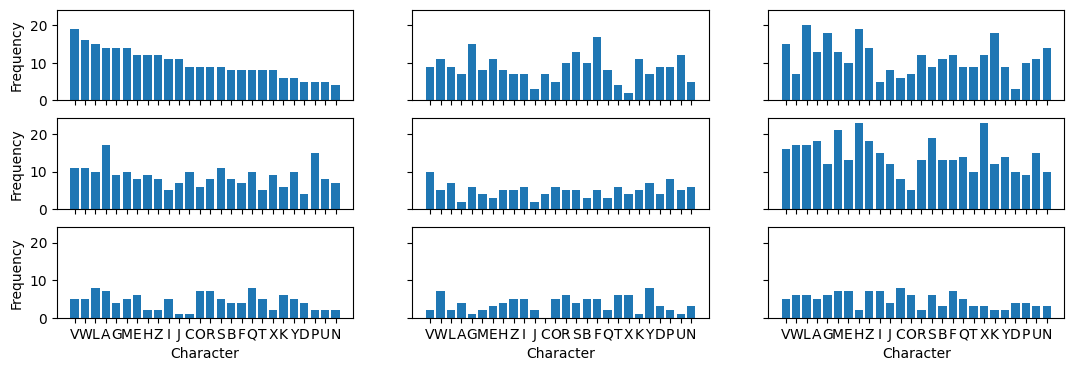

In [6]:
n_msgs = len(text.split("\n\n"))
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(13, 4))
axes = axes.flatten()

for i in range(n_msgs):
    alpha_counts = Counter(text.split("\n\n")[i].split("\n")[1])
    letter_counts = dict(
        sorted(
            {
                chr(char): alpha_counts[chr(char)]
                for char in range(ord("A"), ord("A") + 26)
            }.items(),
            key=lambda item: -item[1],
        )
    )
    # print({letter:count for letter,count in alpha_counts.most_common(10)[1:]})
    axes[i].bar(letter_counts.keys(), letter_counts.values())
# letter_counts
for ax in axes[6:9]:
    ax.set(xlabel="Character")
for ax in axes[0:8:3]:
    ax.set(ylabel="Frequency")

Okay, so our most common letters change based on which message we have.

In the English language (let's pray this is English), the most common letters ought to be T, E, A, O. And there ought to be damn few XYZs. So something is up. Probably a polyalphabetic cipher.

The Kasiski method is used to determine the key length of polyalphabetic substitution ciphers, so let's pull that out. ~Though I'm betting from the first line of each message that the cipher is 5 characters long.~ The first line of each message is the same?

In [4]:
def find_repeated_sequences(ciphertext, min_length=3):
    repeated_sequences = {}
    for i in range(len(ciphertext) - min_length + 1):
        seq = ciphertext[i : i + min_length]
        for j in range(i + min_length, len(ciphertext) - min_length + 1):
            if ciphertext[j : j + min_length] == seq:
                if seq not in repeated_sequences:
                    repeated_sequences[seq] = []
                repeated_sequences[seq].append(i)
                repeated_sequences[seq].append(j)
    # Remove duplicates and sort indices
    for seq in repeated_sequences:
        repeated_sequences[seq] = sorted(list(set(repeated_sequences[seq])))
    return {s: pos for s, pos in repeated_sequences.items() if len(pos) > 1}


def calculate_distances(repeated_sequences):
    distances = {}
    for seq, positions in repeated_sequences.items():
        if len(positions) > 1:
            seq_distances = []
            for i in range(1, len(positions)):
                seq_distances.append(positions[i] - positions[i - 1])
            distances[seq] = seq_distances
    return distances


repeated_sequences = {}
distances = {}
for msg in text.split("\n\n"):
    # print(msg.replace(" ","").split("\n"))
    head, body = msg.replace(" ", "").split("\n")[:2]
    repeated_sequences[head] = find_repeated_sequences(body)
    distances[head] = calculate_distances(repeated_sequences[head])
print(distances)

{'SQKVY44': {'LJE': [74]}, 'SQKVY51': {}, 'SQKVY67': {'ZKN': [89], 'KNK': [89], 'NKQ': [89], 'KQT': [89]}, 'SQKVY74': {'WGK': [144], 'AAQ': [19]}, 'SQKVY86': {'RGP': [78]}, 'XUXJR93': {'WZV': [227], 'VWL': [338], 'KJA': [205], 'XUL': [54], 'KAL': [198], 'HZI': [48], 'XNE': [54], 'HKA': [106], 'QYR': [23]}, 'XUXJR101': {}, 'XUXJR108': {'ZXT': [76]}, 'XUXJR119': {}}


Okay, so there's a chance of an 89 character Vigenère cipher. The other repeated number is 54. But nothing conclusive, and if it's that long I'm not going to brute force the key.


It's ragged right, so maybe this is a playfair cipher. That one comes from the 1800s, so it's a little late for our campaign. If it is, then the lines will have a greatest common factor like 2 or 3.

In [5]:
word_lengths = {}
for msg in text.split("\n\n"):
    head, body = msg.split("\n")[:2]
    word_lengths[head] = [len(w) for w in body.split(" ")]
word_lengths

{'SQKVY44': [20, 18, 17, 20, 24, 22, 21, 18, 21, 19, 18, 19, 20],
 'SQKVY51': [17, 19, 17, 17, 21, 20, 18, 19, 21, 19, 21, 15],
 'SQKVY67': [13, 14, 19, 15, 16, 15, 20, 19, 18, 20, 20, 23, 20, 22, 20, 20],
 'SQKVY74': [20, 19, 17, 19, 16, 22, 22, 20, 20, 23, 23, 8],
 'SQKVY86': [18, 21, 13, 17, 19, 18, 17, 8],
 'XUXJR93': [19,
  16,
  16,
  17,
  14,
  17,
  18,
  16,
  18,
  20,
  18,
  18,
  21,
  20,
  20,
  15,
  14,
  19,
  21,
  15,
  18],
 'XUXJR101': [18, 17, 15, 15, 16, 14, 16, 8],
 'XUXJR108': [17, 19, 18, 15, 17, 8],
 'XUXJR119': [18, 15, 18, 14, 18, 16, 17, 7]}

Nope, time to think like a spy. Or ask the DM. What's the author's favorite phrase? (Especially an 89 character one)

To find out, we go to the next notebook.